In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import qnm
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps
import argparse
import astropy.units as u
import time
import sys
import re

In [6]:
file = open("BBH:1107_realisation0.txt")
header = file.readline()[2:]
mass_patt = r"remnant_mass=(\d+\.\d+),"
remnant_mass = float(re.search(mass_patt, header).group(1))
chi_patt = r"remnant_chi=(\d+\.\d+),"
remnant_chi = float(re.search(chi_patt, header).group(1))


## Creating waveform

In [9]:
# from postmerger
h220 = [0.15659109]
h221 = [0.45621682]
h330 = [0.06022312]
h331 = [0.18205483]

phase220 = 0.392
phase221 = -1.169 + np.pi
phase330 = -1.702
phase331 = -1.897

# Used from calibration
[signalH_noise, signalL_noise, NR_signal22_33, time_arr] = np.loadtxt("BBH:1107_realisation0.txt")
[signalH_noise, signalL_noise, NR_signal22, time_arr] = np.loadtxt("BBH:1107_only22.txt")
[signalH_noise, signalL_noise, NR_signal33, time_arr] = np.loadtxt("BBH:1107_only33.txt")

# signal generation
mass = qnm_filter.Filter.mass_unit(remnant_mass)
omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=remnant_chi)[0]
omega221 = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=remnant_chi)[0]
omega330 = qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=remnant_chi)[0]
# omega331 = qnm.modes_cache(s=-2,l=3,m=3,n=1)(a=remnant_chi)[0]

signal220 = 1e-21*np.real(h220 * np.exp(-1j * omega220 * np.abs(time_arr / mass)+phase220))
signal221 = 1e-21*np.real(h221 * np.exp(-1j * omega221 * np.abs(time_arr / mass)+phase221))
signal330 = 1e-21*np.real(h330 * np.exp(-1j * omega330 * np.abs(time_arr / mass)+phase330))
# signal331 = 1e-21*np.real(h331 * np.exp(-1j * omega331 * np.abs(time_arr / mass)+phase331))

calib_idx = [np.argmin(abs(time_arr - 15*mass))]
signal22 = signal220+signal221
rescale22 = NR_signal22[calib_idx] / signal22[calib_idx]
signal22 *= rescale22
signal33 = signal330
rescale33 = NR_signal33[calib_idx] / signal33[calib_idx]
signal33 *= rescale33

In [10]:
# pl.plot(time_arr, signal221)
# # pl.plot(time_arr, NR_signal220)
# pl.xlim(-0.01, 0.03)
# pl.axvline(10*mass, c='r', ls='--')
# pl.axvline(20*mass, c='r', ls='--')

## Analysing signal

In [11]:
time_offset = 10
model_list_filt = [(2,2,0,'p'),(2,2,1,'p')]
mass_unit = qnm_filter.Filter.mass_unit(remnant_mass)
t0 = 0

In [12]:
delta_mass = 2 #0.1
delta_chi = 0.03 #0.005
massspace = np.arange(45, 140, delta_mass)
chispace = np.arange(0., 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

input = dict(model_list=model_list_filt,
             t_init=t0+time_offset*mass_unit,
             segment_length=0.2,
             srate=4096,
             ra=None, dec=None,
             flow=20, 
             remove_mean=False)
output_str = ''
for item in input['model_list']:
    output_str += f"{item[0]}{item[1]}{item[2]}+"
filter_str = output_str.rstrip('+')

temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 4*1e-22**2
temp_index = np.arange(0, 1, 1/input['srate'])
white_acf = qnm_filter.RealData(temp_acf, index = temp_index)

In [13]:
analysing = signal22

fit = qnm_filter.Network(**input)
fit.original_data = {}
fit.original_data['H1'] = qnm_filter.RealData(analysing, index=time_arr)
fit.original_data['L1'] = qnm_filter.RealData(analysing, index=time_arr)
fit.detector_alignment()
fit.condition_data('original_data', **input)
fit.acfs = {}
fit.acfs['H1'] = white_acf
fit.acfs['L1'] = white_acf
fit.cholesky_decomposition()
fit.first_index()

fit.pure_nr = {}
fit.pure_nr['H1'] = qnm_filter.RealData(analysing, index=time_arr)
fit.pure_nr['L1'] = qnm_filter.RealData(analysing, index=time_arr)
fit.condition_data('pure_nr')
SNR = np.sqrt(2*fit.compute_SNR(fit.truncate_data(fit.original_data)['H1'], fit.truncate_data(fit.pure_nr)['H1'], 'H1', False)**2)


In [14]:
likelihood_data, evidence = qnm_filter.parallel_compute(
    fit, massspace, chispace, num_cpu=6, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

Text(0, 0.5, '$\\chi_f$')

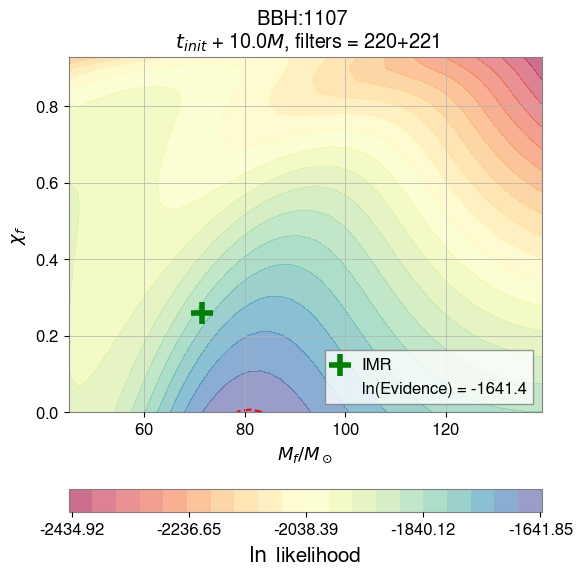

In [15]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors='red',
                    linestyles='--')
ax.scatter(x=remnant_mass, y=remnant_chi, s=255, marker='+',
           c='g', linewidths=4, label='IMR')
ax.plot(np.NaN, np.NaN, '-', color='none',
        label='ln(Evidence) = %.1F' % evidence)

cbar = fig.colorbar(contours, orientation="horizontal",
                    pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data),
               np.max(likelihood_data), 5))

ax.set_title('BBH:1107 \n $t_{init}$ + ' + str((input['t_init']-t0)/mass_unit) +
             r'$M$, filters = ' + filter_str)
pl.legend(loc='lower right')
pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)


In [40]:
index_spacing = 2
initial_offset, num_iteration = qnm_filter.time_to_index(fit, index_spacing, 10*mass_unit, 25*mass_unit)

In [41]:
fit.first_index()
t_array, evidence220 = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = 6, 
                                                           verbosity=False, model_list = [(2, 2, 0, "p")])

In [42]:
fit.first_index()
t_array, evidence220_221 = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = 6, 
                                                           verbosity=False, model_list = [(2, 2, 0, "p"),(2,2,1,"p")])

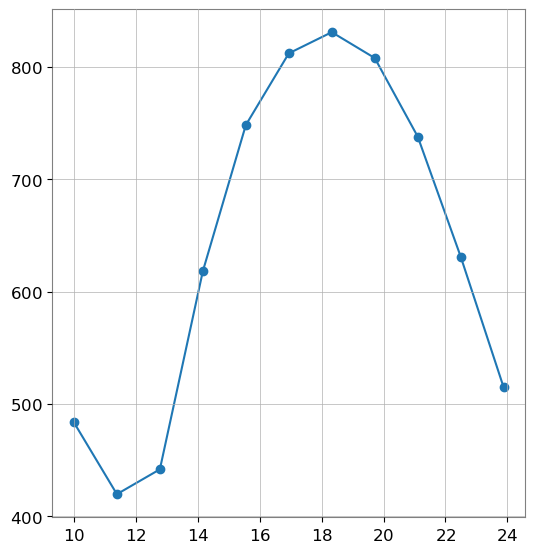

In [43]:
pl.plot(t_array/mass_unit, evidence220_221 - evidence220, marker='o')

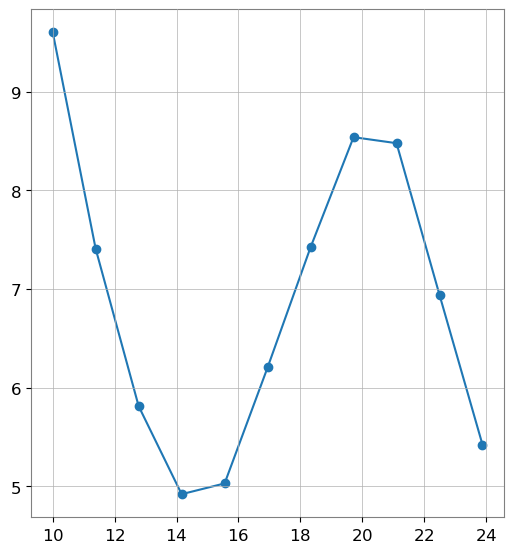

## Automated

In [20]:
def create_signal(phase):
    # from postmerger
    h220 = [0.15659109]
    h221 = [0.45621682]
    h330 = [0.06022312]
    h331 = [0.18205483]
    
    phase220 = 0.392
    phase221 = -1.169 + phase
    phase330 = -1.702
    phase331 = -1.897
    
    # Used from calibration
    [signalH_noise, signalL_noise, NR_signal22_33, time_arr] = np.loadtxt("BBH:1107_realisation0.txt")
    [signalH_noise, signalL_noise, NR_signal22, time_arr] = np.loadtxt("BBH:1107_only22.txt")
    [signalH_noise, signalL_noise, NR_signal33, time_arr] = np.loadtxt("BBH:1107_only33.txt")
    
    # signal generation
    mass = qnm_filter.Filter.mass_unit(remnant_mass)
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=remnant_chi)[0]
    omega221 = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=remnant_chi)[0]
    omega330 = qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=remnant_chi)[0]
    # omega331 = qnm.modes_cache(s=-2,l=3,m=3,n=1)(a=remnant_chi)[0]
    
    signal220 = 1e-21*np.real(h220 * np.exp(-1j * omega220 * np.abs(time_arr / mass)+phase220))
    signal221 = 1e-21*np.real(h221 * np.exp(-1j * omega221 * np.abs(time_arr / mass)+phase221))
    signal330 = 1e-21*np.real(h330 * np.exp(-1j * omega330 * np.abs(time_arr / mass)+phase330))
    # signal331 = 1e-21*np.real(h331 * np.exp(-1j * omega331 * np.abs(time_arr / mass)+phase331))
    
    calib_idx = [np.argmin(abs(time_arr - 15*mass))]
    signal22 = signal220+signal221
    rescale22 = NR_signal22[calib_idx] / signal22[calib_idx]
    signal22 *= rescale22
    signal33 = signal330
    rescale33 = NR_signal33[calib_idx] / signal33[calib_idx]
    signal33 *= rescale33
    return time_arr, signal22, signal33

def analyse_signal(analysing, time_arr):
    fit = qnm_filter.Network(**input)
    fit.original_data = {}
    fit.original_data['H1'] = qnm_filter.RealData(analysing, index=time_arr)
    fit.original_data['L1'] = qnm_filter.RealData(analysing, index=time_arr)
    fit.detector_alignment()
    fit.condition_data('original_data', **input)
    fit.acfs = {}
    fit.acfs['H1'] = white_acf
    fit.acfs['L1'] = white_acf
    fit.cholesky_decomposition()
    fit.first_index()
    
    fit.pure_nr = {}
    fit.pure_nr['H1'] = qnm_filter.RealData(analysing, index=time_arr)
    fit.pure_nr['L1'] = qnm_filter.RealData(analysing, index=time_arr)
    fit.condition_data('pure_nr')
    SNR = np.sqrt(2*fit.compute_SNR(fit.truncate_data(fit.original_data)['H1'], fit.truncate_data(fit.pure_nr)['H1'], 'H1', False)**2)
    index_spacing = 2
    initial_offset, num_iteration = qnm_filter.time_to_index(fit, index_spacing, 10*mass_unit, 25*mass_unit)
    fit.first_index()
    t_array, evidence220 = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                               initial_offset, massspace, chispace, num_cpu = 12, 
                                                               verbosity=False, model_list = [(2, 2, 0, "p")])
    fit.first_index()
    t_array, evidence220_221 = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                               initial_offset, massspace, chispace, num_cpu = 12, 
                                                               verbosity=False, model_list = [(2, 2, 0, "p"),(2,2,1,"p")])
    return t_array, evidence220, evidence220_221

def phase_dependence(phase):
    time_arr, signal22, signal33 = create_signal(phase)
    t_array, evidence220, evidence220_221 = analyse_signal(signal22, time_arr)
    pl.plot(t_array/mass_unit, evidence220_221 - evidence220, marker='o')

2.318085499604543


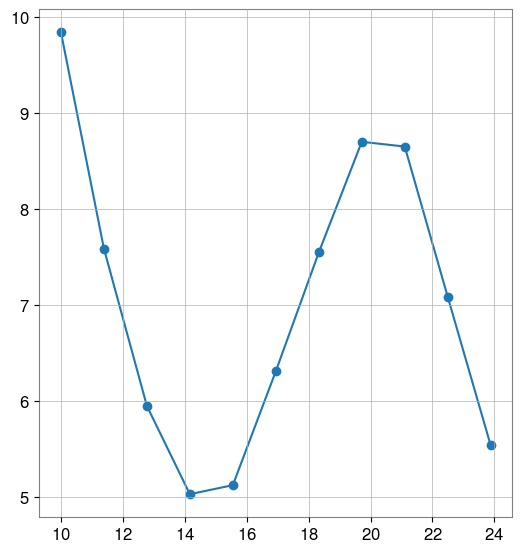

In [21]:
import time
tic = time.time()
phase_dependence(0)
toc = time.time()
print((toc-tic)/60)